# Topic Modeling with Amortized LDA

In this tutorial, we will explore how to run the amortized Latent Dirichlet Allocation (LDA) model implementation in scvi-tools. LDA is a topic modelling method first introduced in the natural language processing field. By treating each cell as a document and each gene expression count as a word, we can carry over the method to the single-cell biology field.

Below, we will train the model over a dataset, plot the topics over a UMAP of the reference set, and inspect the topics for characteristic gene sets.

As an example, we use the PBMC 10K dataset from 10x Genomics.


In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 231 kB 13.2 MB/s 
     |████████████████████████████████| 678 kB 60.1 MB/s 
     |████████████████████████████████| 242 kB 76.4 MB/s 
     |████████████████████████████████| 127 kB 58.2 MB/s 
     |████████████████████████████████| 813 kB 37.8 MB/s 
     |████████████████████████████████| 212 kB 66.5 MB/s 
     |████████████████████████████████| 1.4 MB 60.7 MB/s 
     |████████████████████████████████| 2.0 MB 51.7 MB/s 
     |████████████████████████████████| 3.2 MB 43.5 MB/s 
     |████████████████████████████████| 41 kB 88 kB/s 
     |████████████████████████████████| 8.8 MB 37.1 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 829 kB 45.9 MB/s 
     |████████████████████████████████| 636 kB 45.4 MB/s 
     |████████████████████████████████| 282 kB 74.1 MB/s 
     |████████████████████████████████| 125 kB 70.9 MB/s 
     |████████████████████████████████| 1.3 MB 51.4 MB/s 
     |█████████████

In [2]:
import os

import anndata
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi

%matplotlib inline

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Load and process data

Load the 10x genomics PBMC dataset. Generally, it is good practice for LDA to remove ubiquitous genes, to prevent the model from modeling these genes as a separate topic. Here, we first filter out all mitochrondrial genes, then select the top 1000 variable genes with seurat_v3 method from the remaining genes.

In [7]:
save_path = "data"
adata = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true")

adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

adata = adata[:, ~adata.var_names.str.startswith("MT-")]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True)

Trying to set attribute `.uns` of view, copying.


# Create and fit `AmortizedLDA` model

Here, we initialize and fit an `AmortizedLDA` model on the dataset. We pick 10 topics to model in this case.

In [12]:
n_topics = 10

scvi.model.AmortizedLDA.setup_anndata(adata, layer = "counts")
model = scvi.model.AmortizedLDA(adata, n_topics = n_topics)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 6855 cells, 1000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


<div class="alert alert-info">
Note

By default we train with KL annealing which means the effective loss will generally not decrease steadily in the beginning. Our Pyro implementations present this train loss term as the `elbo_train` in the progress bar which is misleading. We plan on correcting this in the future.

</div>

In [13]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f'you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop')


Epoch 1000/1000: 100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s, v_num=1, elbo_train=1.85e+7]


## Visualizing learned topics

By calling `model.get_latent_representation()`, the model will compute a Monte Carlo estimate of the topic proportions for each cell. Since we use a logistic-Normal distribution to approximate the Dirichlet distribution, the model cannot compute the analytic mean. The number of samples used to compute the latent representation can be configured with the optional argument `n_samples`.

In [14]:
topic_prop = model.get_latent_representation()
topic_prop.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
index,,,,,,,,,,
AAACCCAAGATTGTGA-1,0.116617,0.001366,0.000594,0.000373,0.860557,0.000520,0.000148,0.016374,0.000975,0.002476
AAACCCACATCGGTTA-1,0.005701,0.000541,0.000526,0.000198,0.990339,0.000591,0.000090,0.000070,0.000453,0.001490
AAACCCAGTACCGCGT-1,0.336621,0.005427,0.002489,0.000969,0.468240,0.003176,0.000966,0.177522,0.001650,0.002940
AAACCCAGTATCGAAA-1,0.002727,0.005145,0.002466,0.964663,0.003100,0.010731,0.002085,0.003619,0.002571,0.002892
AAACCCAGTCGTCATA-1,0.000554,0.001495,0.001152,0.990863,0.000723,0.001862,0.000636,0.001304,0.000536,0.000874


In [15]:
# Save topic proportions in obsm and obs columns.
adata.obsm["X_LDA"] = topic_prop
for i in range(n_topics):
  adata.obs[f"LDA_topic_{i}"] = topic_prop[[f"topic_{i}"]]

### Plot UMAP

In [16]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added = "leiden_scVI", resolution = 0.8)

# Save UMAP to custom .obsm field.
adata.obsm["raw_counts_umap"] = adata.obsm["X_umap"].copy()

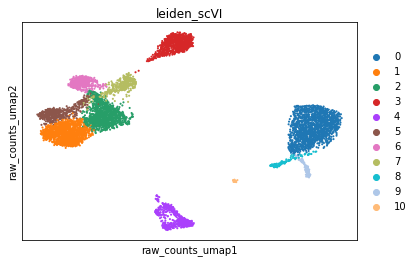

In [17]:
sc.pl.embedding(adata, "raw_counts_umap", color = ["leiden_scVI"])

### Color UMAP by topic proportions

By coloring by UMAP by topic proportions, we find that the learned topics are generally dominant in cells close together in the UMAP space. In some cases, a topic is dominant in multiple clusters in the UMAP, which indicates similarilty between these clusters despite being far apart in the plot. This is not surprising considering that UMAP does not preserve local relationships beyond a certain threshold.

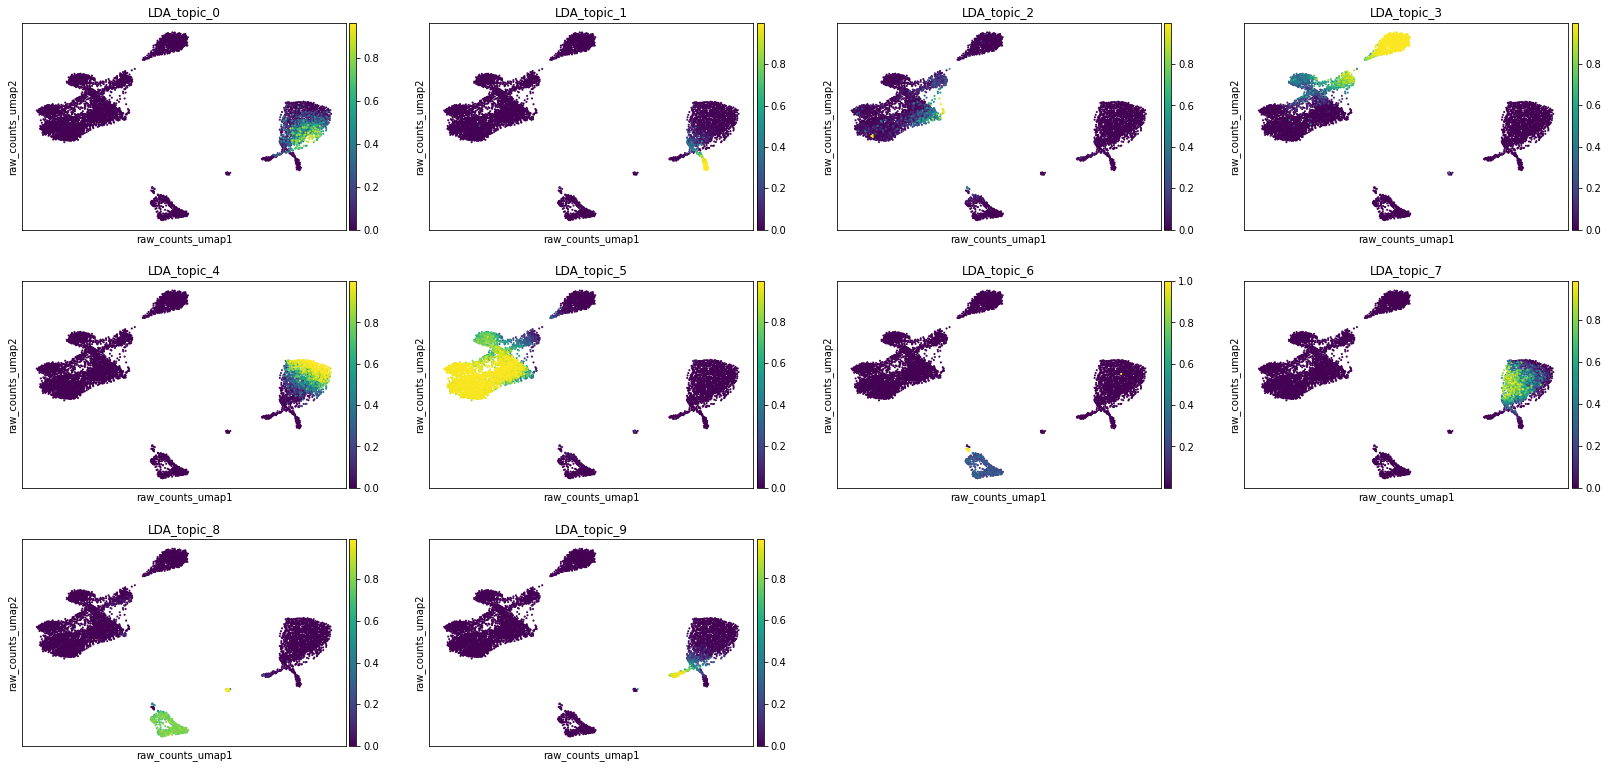

In [18]:
sc.pl.embedding(adata, "raw_counts_umap", color = [f"LDA_topic_{i}" for i in range(n_topics)])

### Plot UMAP in topic space

In [19]:
sc.pp.neighbors(adata, use_rep="X_LDA", n_neighbors = 20, metric="hellinger")
sc.tl.umap(adata)

# Save UMAP to custom .obsm field.
adata.obsm["topic_space_umap"] = adata.obsm["X_umap"].copy()

/usr/local/lib/python3.7/dist-packages/pynndescent/pynndescent_.py:1503: RuntimeWarning: invalid value encountered in correct_alternative_hellinger
  self._distance_correction(self._neighbor_graph[1]),


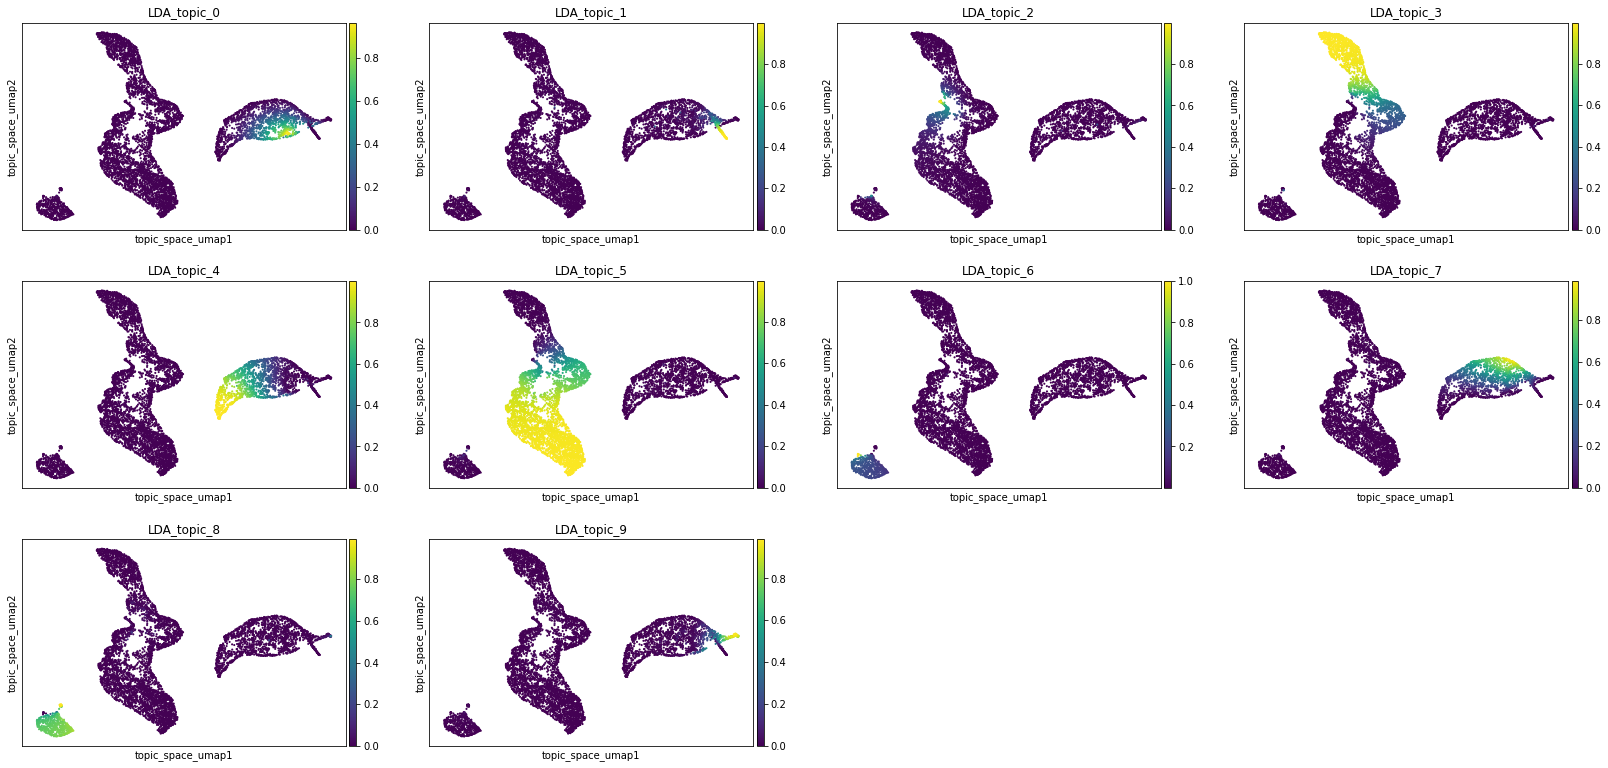

In [20]:
sc.pl.embedding(adata, "topic_space_umap", color = [f"LDA_topic_{i}" for i in range(n_topics)])

### Find top genes per topic

Similar to the topic proportions, `model.get_feature_by_topic()` returns a Monte Carlo estimate of the gene by topic matrix, which contains the proportion that a gene is weighted in each topic. This is also due to another approximation of the Dirichlet with a logistic-Normal distribution. We can inspect each topic in this matrix and sort by proportion allocated to each gene to determine top genes characterizing each topic.

In [28]:
feature_by_topic = model.get_feature_by_topic()
feature_by_topic.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
index,,,,,,,,,,
AL645608.8,0.000001,0.000032,0.000007,0.000002,3.064075e-06,0.000001,0.000006,0.000002,0.000004,0.000002
HES4,0.000008,0.000641,0.000008,0.000007,8.663695e-06,0.000007,0.000010,0.000009,0.000013,0.000011
ISG15,0.000150,0.000610,0.001386,0.001374,2.926504e-04,0.001162,0.000274,0.000694,0.000398,0.000435
TNFRSF18,0.000001,0.000003,0.000296,0.000130,8.745320e-07,0.000350,0.000027,0.000002,0.000017,0.000002
TNFRSF4,0.000002,0.000004,0.000187,0.000061,2.138593e-06,0.000801,0.000009,0.000002,0.000006,0.000005


In [29]:
rank_by_topic = pd.DataFrame()
for i in range(n_topics):
    topic_name = f"topic_{i}"
    topic = feature_by_topic[topic_name].sort_values(ascending=False)
    rank_by_topic[topic_name] = topic.index
    rank_by_topic[f"{topic_name}_prop"] = topic.values

In [30]:
rank_by_topic.head()

,topic_0,topic_0_prop,topic_1,topic_1_prop,topic_2,topic_2_prop,topic_3,topic_3_prop,topic_4,topic_4_prop,topic_5,topic_5_prop,topic_6,topic_6_prop,topic_7,topic_7_prop,topic_8,topic_8_prop,topic_9,topic_9_prop
0,LYZ,0.069025,FTL,0.104881,ACTB,0.187062,ACTB,0.090297,S100A9,0.132848,TMSB4X,0.126401,IGKC,0.259460,FTH1,0.066602,CD74,0.126389,HLA-DRA,0.072207
1,S100A9,0.044466,ACTB,0.067623,TMSB4X,0.131704,TMSB4X,0.089056,S100A8,0.093633,ACTB,0.087818,IGLC2,0.140007,FTL,0.057689,HLA-DRA,0.068171,CD74,0.066772
2,FTL,0.043739,TMSB4X,0.057699,TMSB10,0.084172,GNLY,0.068898,LYZ,0.055077,TMSB10,0.085532,IGHA1,0.094170,LYZ,0.047424,TMSB4X,0.049803,ACTB,0.064793
3,ACTB,0.042760,FTH1,0.056734,ACTG1,0.066966,NKG7,0.052699,FTL,0.044934,JUNB,0.034018,IGLC3,0.042519,TMSB4X,0.037330,TMSB10,0.041632,TMSB4X,0.049217
4,FTH1,0.032328,S100A4,0.028786,S100A4,0.034022,TMSB10,0.040334,ACTB,0.038443,FTL,0.027264,JCHAIN,0.034586,ACTB,0.033221,ACTB,0.041102,HLA-DRB1,0.042463
